In [1]:
# Utils
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Representation
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

import re, sys, unidecode
import wordbatch
from wordbatch.extractors import WordBag, WordHash
from wordbatch.models import FTRL

plt.style.use('fivethirtyeight')

# Para obrrar objetos Pandas y liberar memoria (Problema memory Leak())
#cdll.LoadLibrary("libc.so.6")
#libc = CDLL("libc.so.6")

/root/anaconda3/lib/python3.6/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so | _pywrap_tensorflow_internal


## Load Data

In [2]:
dfNoticias = pd.read_pickle("dfNoticias")

dfNoticias.head()

,Cuerpo,Fecha,Hora,ID,Resumen,Seccion_1,Seccion_2,Seccion_3,Subtema_1,Subtema_2,Subtema_3,Tema_1,Tema_2,Tema_3,Titular,Type
1,\nMarcel Granollers (44°) sorprendió a David F...,20140929,09:57,20140929095927,\nEl español cayó ante su compatriota Marcel G...,Deportes,None,None,Torneos ATP,None,None,Tenis,None,None,\nDavid Ferrer sufrió otra temprana eliminación\n,fid_noticia
2,\nEl Gobierno de Barack Obama ha enviado cuatr...,20140929,07:03,20140929065051,\nLas conversaciones comenzaron el año 2010 y ...,País,Mundo,Mundo,EE.UU.,Relaciones Exteriores,None,Relaciones Exteriores,EE.UU.,Cuba,\nObama ha enviado cuatro solicitudes a Chile ...,fid_noticia
3,\nEste miércoles la Comisión Asesora Presidenc...,20140929,11:37,20140929105234,\nRepresentantes del sector privado acusaron q...,País,None,None,Isapre,None,None,Salud,None,None,\nQuiebre en comisión presidencial de isapres ...,fid_noticia
4,"\nWolfgang Burmann, del Team Avanti, se adjudi...",20140929,10:05,20140929100825,\nEl pedalero del equipo Avanti terminó en el ...,Deportes,None,None,Chilenos,None,None,Ciclismo,None,None,\nWolfgang Burmann ganó el segundo clasificato...,fid_noticia
5,"\nWolfgang Burmann, del Team Avanti, se adjudi...",20140929,10:05,20140929130450,\nEl pedalero del equipo Avanti terminó en el ...,Deportes,None,None,Chilenos,None,None,Ciclismo,None,None,\nWolfgang Burmann ganó el segundo clasificato...,fid_noticia


In [3]:
dfNoticias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250759 entries, 1 to 389889
Data columns (total 16 columns):
Cuerpo       250639 non-null object
Fecha        250759 non-null object
Hora         250759 non-null object
ID           250759 non-null object
Resumen      249632 non-null object
Seccion_1    250459 non-null object
Seccion_2    123240 non-null object
Seccion_3    37532 non-null object
Subtema_1    182753 non-null object
Subtema_2    74385 non-null object
Subtema_3    24247 non-null object
Tema_1       248508 non-null object
Tema_2       116973 non-null object
Tema_3       36153 non-null object
Titular      250759 non-null object
Type         250759 non-null object
dtypes: object(16)
memory usage: 32.5+ MB


In [4]:
#dfNoticias = dfNoticias.sample(frac= 0.2)
#dfNoticias = dfNoticias.sample(frac= 0.5)

In [5]:
print('Selecting useful information...', end='')
_map = {}
#_map2 = {}
#_map3 = {}

_map["Cuerpo"] = []
_map["Seccion"] = []
#_map["Seccion2"] = []
#_map["Seccion3"] = []

for index, row in dfNoticias.iterrows():
    if (row["Seccion_1"] != None and row["Cuerpo"] != None):
        _map["Cuerpo"].append(row["Cuerpo"]) 
        _map["Seccion"].append(row["Seccion_1"] )
        #_map["Seccion2"].append(row["Seccion_2"])
        #_map["Seccion3"].append(row["Seccion_3"])
    
        
print('done.')

Selecting useful information...done.


In [6]:
#print(_map2["Seccion"])

In [7]:
df = pd.DataFrame(_map)
numberOfDuplicates = df.shape[0]
print('Number of data before dropping duplicates: {}'.format(df.shape[0]))
df = df.drop_duplicates(inplace= False)
df.reset_index(drop=True, inplace= True)
numberOfDuplicates -= df.shape[0]
print('Number of data after dropping duplicates : {}'.format(df.shape[0]))
print('\nNumber of duplicated data : {}'.format(numberOfDuplicates))


Number of data before dropping duplicates: 250339
Number of data after dropping duplicates : 238909

Number of duplicated data : 11430


In [8]:
df.head()

,Cuerpo,Seccion
0,\nMarcel Granollers (44°) sorprendió a David F...,Deportes
1,\nEl Gobierno de Barack Obama ha enviado cuatr...,País
2,\nEste miércoles la Comisión Asesora Presidenc...,País
3,"\nWolfgang Burmann, del Team Avanti, se adjudi...",Deportes
4,"\nEl Gobierno, a través de Sernapesca, present...",País


In [9]:
X_untransformed = df['Cuerpo'].reset_index(drop=True)
y_untransformed = df['Seccion'].reset_index(drop=True)

assert X_untransformed.shape[0] == y_untransformed.shape[0], 'X and y dimenssion must be the same.'
print('Number of data: {}'.format(X_untransformed.shape[0]))

Number of data: 238909


In [10]:
y_untransformed

0             Deportes
1                 País
2                 País
3             Deportes
4                 País
5             Deportes
6                 País
7             Deportes
8                 País
9             Deportes
10                País
11                País
12            Deportes
13        Entretención
14               Mundo
15            Deportes
16                País
17                País
18                País
19            Deportes
20            Economía
21        Entretención
22        Entretención
23        Entretención
24                País
25            Deportes
26            Deportes
27            Deportes
28                País
29            Economía
              ...     
238879            País
238880      Tecnología
238881        Deportes
238882        Deportes
238883        Sociedad
238884        Deportes
238885    Entretención
238886           Mundo
238887      Tecnología
238888            País
238889           Mundo
238890        Economía
238891     

In [11]:
classes = df.groupby('Seccion')['Cuerpo'].nunique()

print(classes)
nClasses = classes.shape[0]
print('\nNumber of classes: {}'.format(nClasses))

Seccion
Corporativo        82
Cultura          3128
Deportes        76458
Economía         6750
Entretención    29438
Mundo           31664
País            75180
Sociedad         9079
Tecnología       7130
Name: Cuerpo, dtype: int64

Number of classes: 9


# Data Representation

## Input

In [12]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:

spanish_stopwords = stopwords.words('spanish')
def normalize_text(text):
    return u" ".join([x for x in [y for y in text.lower().strip().split(" ")] 
                      if len(x) > 1 and x not in spanish_stopwords])

X_untransformed = X_untransformed
n_docs = X_untransformed.shape[0]
n_cpu = 20

batch_size = int(n_docs/n_cpu)

wb = wordbatch.WordBatch(normalize_text, 
                         extractor=(WordBag, {"hash_ngrams": 1, "hash_ngrams_weights": [1.0, 1.0],
                                              "hash_size": 2**28, "norm": "l2", "tf": 1.0,
                                              "idf": 1.0}), procs=n_cpu, n_words=1000, minibatch_size=batch_size)
wb.dictionary_freeze = True
word_comment = wb.fit_transform(list(X_untransformed),reset= False)
X_transformed = word_comment[:, np.array(np.clip(word_comment.getnnz(axis=0) - 1, 0, 1), dtype = bool)]

Normalize text
Extract wordbags


In [14]:
# dense_transformer = DenseTransformer()
# X_train = dense_transformer.fit_transform(X_sparse)
X = X_transformed
print('Number of features: {}'.format(X.shape[1]))

Number of features: 1000


In [15]:
# import _pickle as pickle
# with open('tfidf.pk', 'wb') as file:
#     pickle.dump(tfidf, file)

## Output

In [16]:
# Y = pd.get_dummies(y_untransformed)
Y = y_untransformed
# Y = Y.values
Y = Y.reset_index(drop=True)

In [17]:
import unidecode

def remove_accents(a):
    return unidecode.unidecode(a)

In [18]:
from tecnosmartlib import DataObject
data = DataObject(X,Y.apply(remove_accents))

In [19]:
labels = [remove_accents(x) for x in list(data.Y.unique())]
print(labels)

['Deportes', 'Pais', 'Entretencion', 'Mundo', 'Economia', 'Cultura', 'Sociedad', 'Tecnologia', 'Corporativo']


In [20]:
data.set_train_test(0.8)

True

In [21]:
print(data.Y_train.reset_index(drop=True))

         index       Seccion
0       203675          Pais
1       129899          Pais
2        59267      Sociedad
3        92572          Pais
4       111870          Pais
5       130226      Deportes
6        42142         Mundo
7        94171         Mundo
8        87236          Pais
9       176270      Deportes
10      181226         Mundo
11       28445      Deportes
12      204917      Deportes
13      226662      Deportes
14       43114          Pais
15       40313      Deportes
16       26915  Entretencion
17       76678          Pais
18       70267  Entretencion
19      109985      Deportes
20       24974         Mundo
21       68926          Pais
22      153364          Pais
23      159971       Cultura
24       17847      Deportes
25      196157      Sociedad
26       56791      Deportes
27      207654         Mundo
28       31587  Entretencion
29      127365      Deportes
...        ...           ...
191097  119839      Deportes
191098   66968          Pais
191099  177176

# Models

In [22]:
from tensorflow.contrib.learn import LinearClassifier
from tensorflow.contrib.learn import DNNClassifier

/root/anaconda3/lib/python3.6/site-packages/tensorflow/contrib/lite/toco/python/_tensorflow_wrap_toco.so | _tensorflow_wrap_toco


In [37]:
help(DNNClassifier)

Help on class DNNClassifier in module tensorflow.contrib.learn.python.learn.estimators.dnn:

class DNNClassifier(tensorflow.contrib.learn.python.learn.estimators.estimator.Estimator)
 |  A classifier for TensorFlow DNN models.
 |  
 |  Example:
 |  
 |  ```python
 |  sparse_feature_a = sparse_column_with_hash_bucket(...)
 |  sparse_feature_b = sparse_column_with_hash_bucket(...)
 |  
 |  sparse_feature_a_emb = embedding_column(sparse_id_column=sparse_feature_a,
 |                                          ...)
 |  sparse_feature_b_emb = embedding_column(sparse_id_column=sparse_feature_b,
 |                                          ...)
 |  
 |  estimator = DNNClassifier(
 |      feature_columns=[sparse_feature_a_emb, sparse_feature_b_emb],
 |      hidden_units=[1024, 512, 256])
 |  
 |  # Or estimator using the ProximalAdagradOptimizer optimizer with
 |  # regularization.
 |  estimator = DNNClassifier(
 |      feature_columns=[sparse_feature_a_emb, sparse_feature_b_emb],
 |      hidden_

In [28]:
tf.set_random_seed(42)
feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=1000)]
#os.system("rm -f -R  ./model-parallel/seccion")
#classifier = LinearClassifier(n_classes=nClasses, label_keys=labels, feature_columns=feature_columns, model_dir='./model-parallel/seccion')
# ,model_dir='./model-parallel/seccion_dnn'
classifier = DNNClassifier(n_classes=nClasses, label_keys=labels, feature_columns=feature_columns,
                           hidden_units=[2000, 1000, 100],
                           dropout=0.8,
                           weight_column_name='class_weights',
                           model_dir = './model-parallel/seccion_dnn',
                           config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 500,
                                                               save_checkpoints_secs = None)
                          )

INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3b4d964390>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 500, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': './model-parallel/seccion_dnn'}


In [33]:
epochs = 100000

# Define the test inputs
def get_train_inputs():
    print("Paso por aca.........................")
    X_ = data.X_train
    Y_ = data.Y_train
    X_ = X_.todense()
    x = X_
    Y_ = Y_['Seccion'].reset_index(drop=True)
#     y = y.apply(remove_accents)
#     y = y.values

    y = Y_.values
    
    # computing lengths of each class
    sizes = {label: Y_[Y_ == label].shape[0] for label in labels}
#     print(sizes)

    # creating weights for each sample
    scale_factor = 10e3
    weights = np.asarray([1.0/sizes[label] for label in y])
    weights = scale_factor*weights
    weights = weights[:,np.newaxis]
    print('weights shape: {}'.format(weights.shape))
    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': x, 'class_weights': weights}, y[:,np.newaxis], shuffle=True, batch_size=500, num_epochs=epochs)
    return dataset

def get_test_inputs():
    X_ = data.X_test_dense
    Y_ = data.Y_test
#     X_ = X_.todense()
    x = X_
    Y_ = Y_['Seccion'].reset_index(drop=True)
    y = Y_.values
    
    # computing lengths of each class
    sizes = {label: Y_[Y_ == label].shape[0] for label in labels}
#     print(sizes)

    # creating weights for each sample
    scale_factor = 10e3
    weights = np.asarray([1.0/sizes[label] for label in y])
    weights = scale_factor*weights
    weights = weights[:,np.newaxis]
    print('weights shape: {}'.format(weights.shape))
    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': x, 'class_weights': weights}, y[:,np.newaxis], shuffle=False)
    return dataset

In [34]:
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    input_fn= get_test_inputs(),
    every_n_steps=500,
    early_stopping_metric="accuracy",
    early_stopping_rounds = 5000)

classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)

weights shape: (47782, 1)
Paso por aca.........................
weights shape: (191127, 1)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn/model.ckpt-77507
INFO:tensorflow:Saving checkpoints for 77508 into ./model-parallel/seccion_dnn/model.ckpt.
INFO:tensorflow:Starting evaluation at 2018-08-06-15:38:46
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn/model.ckpt-77508
INFO:tensorflow:Finished evaluation at 2018-08-06-15:38:50
INFO:tensorflow:Saving dict for global step 77508: accuracy = 0.9417215, global_step = 77508, loss = 0.21223465
INFO:tensorflow:Validation (step 77508): loss = 0.21223465, accuracy = 0.9417215, global_step = 77508
INFO:tensorflow:loss = 0.20244068, step = 77508
INFO:tensorflow:global_step/sec: 10.5782
INFO:tensorflow:loss = 0.13326547, step = 77608 (4.481 sec)
INFO:tensorflow:global_step/sec: 22.6249
INFO:tensorflow:loss = 0.12506345, step = 77708 (4.419 sec)
INFO:tensorflow:

INFO:tensorflow:loss = 0.12418147, step = 81408 (4.403 sec)
INFO:tensorflow:Saving checkpoints for 81508 into ./model-parallel/seccion_dnn/model.ckpt.
INFO:tensorflow:global_step/sec: 19.7478
INFO:tensorflow:Starting evaluation at 2018-08-06-15:42:20
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn/model.ckpt-81508
INFO:tensorflow:Finished evaluation at 2018-08-06-15:42:24
INFO:tensorflow:Saving dict for global step 81508: accuracy = 0.93883985, global_step = 81508, loss = 0.22318101
INFO:tensorflow:Validation (step 81508): loss = 0.22318101, accuracy = 0.93883985, global_step = 81508
INFO:tensorflow:loss = 0.18932016, step = 81508 (9.526 sec)
INFO:tensorflow:global_step/sec: 11.3306
INFO:tensorflow:loss = 0.14840579, step = 81608 (4.362 sec)
INFO:tensorflow:global_step/sec: 22.5853
INFO:tensorflow:loss = 0.14159842, step = 81708 (4.429 sec)
INFO:tensorflow:global_step/sec: 22.8489
INFO:tensorflow:loss = 0.11661023, step = 81808 (4.376 sec)
INFO:tensorflow:global_

INFO:tensorflow:global_step/sec: 21.2624
INFO:tensorflow:Starting evaluation at 2018-08-06-15:45:53
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn/model.ckpt-85508
INFO:tensorflow:Finished evaluation at 2018-08-06-15:45:57
INFO:tensorflow:Saving dict for global step 85508: accuracy = 0.9345538, global_step = 85508, loss = 0.23931228
INFO:tensorflow:Validation (step 85508): loss = 0.23931228, accuracy = 0.9345538, global_step = 85508
INFO:tensorflow:loss = 0.115854494, step = 85508 (8.934 sec)
INFO:tensorflow:global_step/sec: 11.593
INFO:tensorflow:loss = 0.14651567, step = 85608 (4.395 sec)
INFO:tensorflow:global_step/sec: 22.8749
INFO:tensorflow:loss = 0.18385199, step = 85708 (4.371 sec)
INFO:tensorflow:global_step/sec: 22.404
INFO:tensorflow:loss = 0.19574772, step = 85808 (4.464 sec)
INFO:tensorflow:global_step/sec: 22.4442
INFO:tensorflow:loss = 0.17345093, step = 85908 (4.455 sec)
INFO:tensorflow:Saving checkpoints for 86008 into ./model-parallel/seccion_d

INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn/model.ckpt-89508
INFO:tensorflow:Finished evaluation at 2018-08-06-15:49:32
INFO:tensorflow:Saving dict for global step 89508: accuracy = 0.9307339, global_step = 89508, loss = 0.25247952
INFO:tensorflow:Validation (step 89508): loss = 0.25247952, accuracy = 0.9307339, global_step = 89508
INFO:tensorflow:loss = 0.10001661, step = 89508 (9.172 sec)
INFO:tensorflow:global_step/sec: 11.3222
INFO:tensorflow:loss = 0.13418448, step = 89608 (4.343 sec)
INFO:tensorflow:global_step/sec: 22.9532
INFO:tensorflow:loss = 0.13379535, step = 89708 (4.356 sec)
INFO:tensorflow:global_step/sec: 22.8782
INFO:tensorflow:loss = 0.10660626, step = 89808 (4.372 sec)
INFO:tensorflow:global_step/sec: 22.8462
INFO:tensorflow:loss = 0.11461977, step = 89908 (4.377 sec)
INFO:tensorflow:Saving checkpoints for 90008 into ./model-parallel/seccion_dnn/model.ckpt.
INFO:tensorflow:global_step/sec: 21.1675
INFO:tensorflow:Starting evaluation at 2018

INFO:tensorflow:Finished evaluation at 2018-08-06-15:53:05
INFO:tensorflow:Saving dict for global step 93508: accuracy = 0.92602193, global_step = 93508, loss = 0.27041274
INFO:tensorflow:Validation (step 93508): loss = 0.27041274, accuracy = 0.92602193, global_step = 93508
INFO:tensorflow:loss = 0.14615516, step = 93508 (9.265 sec)
INFO:tensorflow:global_step/sec: 11.1894
INFO:tensorflow:loss = 0.11030301, step = 93608 (4.353 sec)
INFO:tensorflow:global_step/sec: 23.3793
INFO:tensorflow:loss = 0.1647443, step = 93708 (4.278 sec)
INFO:tensorflow:global_step/sec: 22.7436
INFO:tensorflow:loss = 0.09993539, step = 93808 (4.395 sec)
INFO:tensorflow:global_step/sec: 23.2924
INFO:tensorflow:loss = 0.12135579, step = 93908 (4.294 sec)
INFO:tensorflow:Saving checkpoints for 94008 into ./model-parallel/seccion_dnn/model.ckpt.
INFO:tensorflow:global_step/sec: 22.1689
INFO:tensorflow:Starting evaluation at 2018-08-06-15:53:28
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn/

INFO:tensorflow:Validation (step 97508): loss = 0.29701325, accuracy = 0.9197176, global_step = 97508
INFO:tensorflow:loss = 0.10339487, step = 97508 (8.982 sec)
INFO:tensorflow:global_step/sec: 11.4209
INFO:tensorflow:loss = 0.12881081, step = 97608 (4.349 sec)
INFO:tensorflow:global_step/sec: 23.3729
INFO:tensorflow:loss = 0.16861342, step = 97708 (4.279 sec)
INFO:tensorflow:global_step/sec: 23.1221
INFO:tensorflow:loss = 0.101580925, step = 97808 (4.326 sec)
INFO:tensorflow:global_step/sec: 22.7924
INFO:tensorflow:loss = 0.1361635, step = 97908 (4.386 sec)
INFO:tensorflow:Saving checkpoints for 98008 into ./model-parallel/seccion_dnn/model.ckpt.
INFO:tensorflow:global_step/sec: 21.4387
INFO:tensorflow:Starting evaluation at 2018-08-06-15:57:01
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn/model.ckpt-98008
INFO:tensorflow:Finished evaluation at 2018-08-06-15:57:05
INFO:tensorflow:Saving dict for global step 98008: accuracy = 0.92169863, global_step = 98008, l

INFO:tensorflow:loss = 0.114375785, step = 101508 (9.131 sec)
INFO:tensorflow:global_step/sec: 11.2746
INFO:tensorflow:loss = 0.13990666, step = 101608 (4.476 sec)
INFO:tensorflow:global_step/sec: 23.214
INFO:tensorflow:loss = 0.105339035, step = 101708 (4.309 sec)
INFO:tensorflow:global_step/sec: 22.8345
INFO:tensorflow:loss = 0.13369676, step = 101808 (4.379 sec)
INFO:tensorflow:global_step/sec: 22.9054
INFO:tensorflow:loss = 0.08475357, step = 101908 (4.366 sec)
INFO:tensorflow:Saving checkpoints for 102008 into ./model-parallel/seccion_dnn/model.ckpt.
INFO:tensorflow:global_step/sec: 21.3025
INFO:tensorflow:Starting evaluation at 2018-08-06-16:00:35
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn/model.ckpt-102008
INFO:tensorflow:Finished evaluation at 2018-08-06-16:00:39
INFO:tensorflow:Saving dict for global step 102008: accuracy = 0.9191997, global_step = 102008, loss = 0.30828717
INFO:tensorflow:Validation (step 102008): loss = 0.30828717, accuracy = 0.91

INFO:tensorflow:loss = 0.10400574, step = 105508 (8.835 sec)
INFO:tensorflow:global_step/sec: 11.6043
INFO:tensorflow:loss = 0.091023535, step = 105608 (4.475 sec)
INFO:tensorflow:global_step/sec: 22.8171
INFO:tensorflow:loss = 0.11618049, step = 105708 (4.383 sec)
INFO:tensorflow:global_step/sec: 22.7082
INFO:tensorflow:loss = 0.101090305, step = 105808 (4.403 sec)
INFO:tensorflow:global_step/sec: 23.2535
INFO:tensorflow:loss = 0.095987074, step = 105908 (4.301 sec)
INFO:tensorflow:Saving checkpoints for 106008 into ./model-parallel/seccion_dnn/model.ckpt.
INFO:tensorflow:global_step/sec: 22.3663
INFO:tensorflow:Starting evaluation at 2018-08-06-16:04:10
INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn/model.ckpt-106008
INFO:tensorflow:Finished evaluation at 2018-08-06-16:04:14
INFO:tensorflow:Saving dict for global step 106008: accuracy = 0.9120761, global_step = 106008, loss = 0.33500066
INFO:tensorflow:Validation (step 106008): loss = 0.33500066, accuracy = 0.

KeyboardInterrupt: 

In [35]:
def input_fn_evaluate():
    dataset = {'x': tf.constant(data.X_test_dense)}
    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)

# print(pred_test)

y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)
y_test = data.Y_test['Seccion'].values
y_test = y_test.astype(str)
print('Test shape: {}\nReal shape: {}'.format(y_test_hat.shape, y_test.shape))

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)
print('Accuracy in test: {}'.format(acc))

INFO:tensorflow:Restoring parameters from ./model-parallel/seccion_dnn/model.ckpt-108008
Test shape: (47782,)
Real shape: (47782,)
Accuracy in test: 0.9195303670838391


/root/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=DeprecationWarning)
/root/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

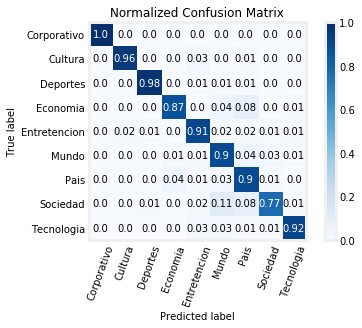

In [36]:
import scikitplot.plotters as skplt
ax = skplt.plot_confusion_matrix(y_test, y_test_hat,normalize=True)
# plt.xticks(rotation=45)

for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

plt.xticks(rotation=70)